In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pybeam.default as pbd

# modify figure text settings
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({ 'mathtext.default' : 'regular' })


In [2]:
# define base model
model = {'type' : 'base',  # model type ('base' or 'ugm')
        'sigma' : 1.0,     # sets sigma, the scaling parameter
    'threshold' : 'fixed', # sets threshold type (fixed, linear, exponential, or weibull)
      'leakage' : True,    # if True, drift rate has leaky integration
        'delay' : False,   # if True, decision threshold motion is delayed
'contamination' : False}   # if True, uniform contamination added to model

# outputs which parameters your model uses
pbd.parse_model(model)


['t_nd', 'w', 'mu', 'l', 'a']

In [5]:
# parameters for data set 0
phi0 = {'t_nd' : 0.25, # non-decision time
           'w' : 0.5,  # relative start point
          'mu' : 1.0,  # drift rate
           'l' : 3.0,  # leakage rate
           'a' : 0.5 } # decision threshold

# parameters for data set 1
phi1 = {'t_nd' : 0.25, # non-decision time
           'w' : 0.5,  # relative start point
          'mu' : 1.0,  # drift rate
           'l' : 3.0,  # leakage rate
           'a' : 0.75 } # decision threshold

# simulate data for parameter set 0
rt0 = pbd.simulate_model(model = model, # directory our model file is in
                           phi = phi0,      # dictionary of model parameters
                        N_sims = 500,
                          seed = 123)       # number of simulated data points

# simulate data for parameter set 1
rt1 = pbd.simulate_model(model = model, # directory our model file is in
                           phi = phi1,      # dictionary of model parameters
                        N_sims = 500,
                          seed = 456)       # number of simulated data points


(-5.0, 5.0)

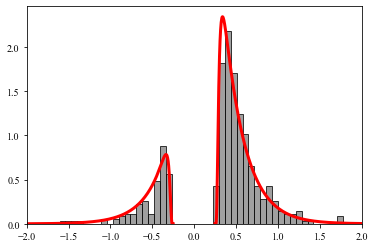

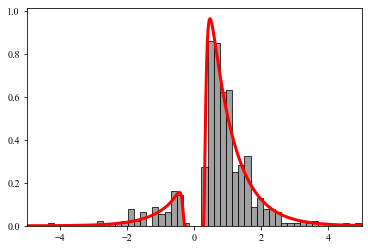

In [6]:
# plot data and model for parameter set 0
pbd.plot_rt(model = model, # directory our model file is in
                    phi = phi0,      # dictionary of model parameters
                     rt = rt0);     # dictionary of rt data

plt.xlim(-2.0, 2.0)

# plot data and model for parameter set 1
pbd.plot_rt(model = model, # directory our model file is in
                    phi = phi1,      # dictionary of model parameters
                     rt = rt1);     # dictionary of rt data

plt.xlim(-5.0, 5.0)


In [7]:
# define model priors
p = {'pt_nd' : 'Uniform("t_nd", lower = 0.0, upper = 0.75)', # prior for non-decision time
        'pw' : 'Uniform("w", lower = 0.3, upper = 0.7)',     # prior for relative start point
       'pmu' : 'Uniform("mu", lower = -5.0, upper = 5.0)',   # prior for drift rate
        'pl' : 'Uniform("l", lower = 0.0, upper = 10.0)',   # prior for the leakage rate
       'pa0' : 'Uniform("a0", lower = 0.1, upper = 1.0)',     # prior for decision threshold 0
       'pa1' : 'Uniform("a1", lower = 0.1, upper = 1.0)'}     # prior for decision threshold 1


In [9]:
# define model conditions
c0 = {'rt' : rt0,      # dictionary containing reaction time data
    't_nd' : 'pt_nd', # sets prior used for non-decision time, references p['pt_nd']
       'w' : 'pw',    # sets prior used for relative start point, references p['pw']
      'mu' : 'pmu',   # sets prior used for the drift rate, references p['pmu']
       'l' : 'pl',   # sets prior used for the leakage rate, references p['pl']
       'a' : 'pa0'}    # sets prior used prior for the threshold, references p['pa0']

c1 = {'rt' : rt1,      # dictionary containing reaction time data
    't_nd' : 'pt_nd', # sets prior used for non-decision time, references p['pt_nd']
       'w' : 'pw',    # sets prior used for relative start point, references p['pw']
      'mu' : 'pmu',   # sets prior used for the drift rate, references p['pmu']
       'l' : 'pl',   # sets prior used for the leakage rate, references p['pl']
       'a' : 'pa1'}    # sets prior used prior for the threshold, references p['pa1']


In [10]:
# dictionary containing our model condtions
cond = { 0 : c0 , 1 : c1 }

# parameter inference
trace = pbd.inference(model = model,               # directory our model file is in
                     priors = p,                   # priors dictionary
                 conditions = cond,                # conditions dictionary 
                    samples = 25000,               # number of samples completed per chain
                     chains = 3,                   # number of chains run
                      cores = 3,                   # number of cpu cores to use
                  file_name = 'leakage_2boundary') # file name output


Multiprocess sampling (3 chains in 3 jobs)
DEMetropolisZ: [a1, a0, l, mu, w, t_nd]


Sampling 3 chains for 0 tune and 25_000 draw iterations (0 + 75_000 draws total) took 99 seconds.


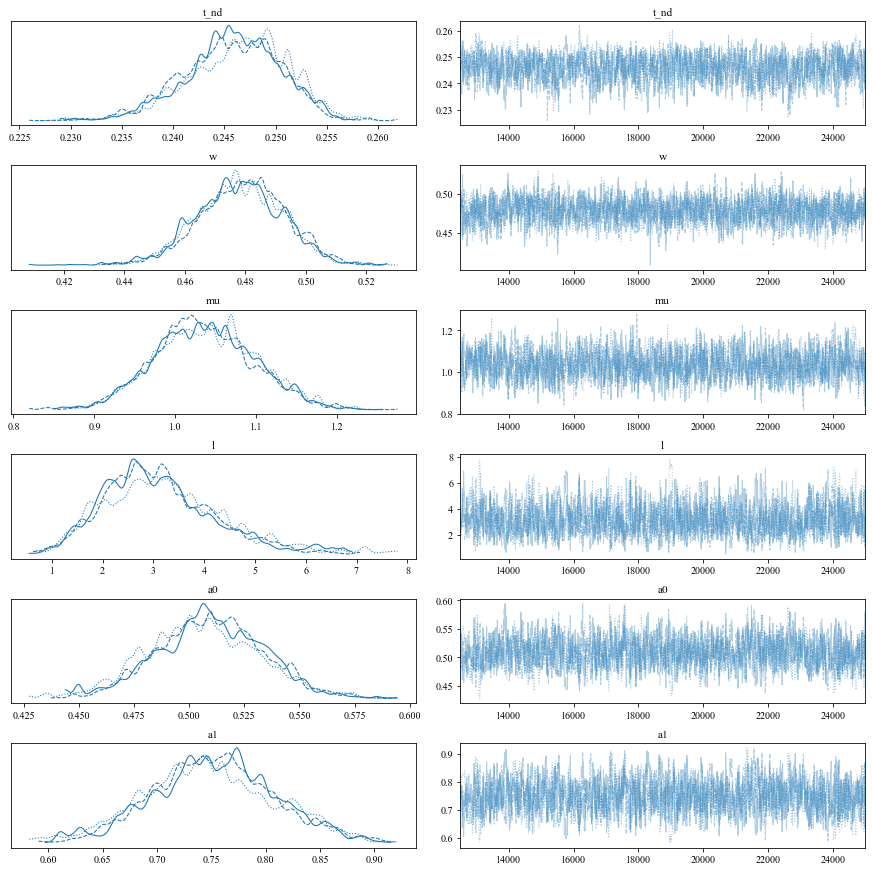

In [11]:
# plot trace
pbd.plot_trace(file_name = 'leakage_2boundary', burnin = 12500);


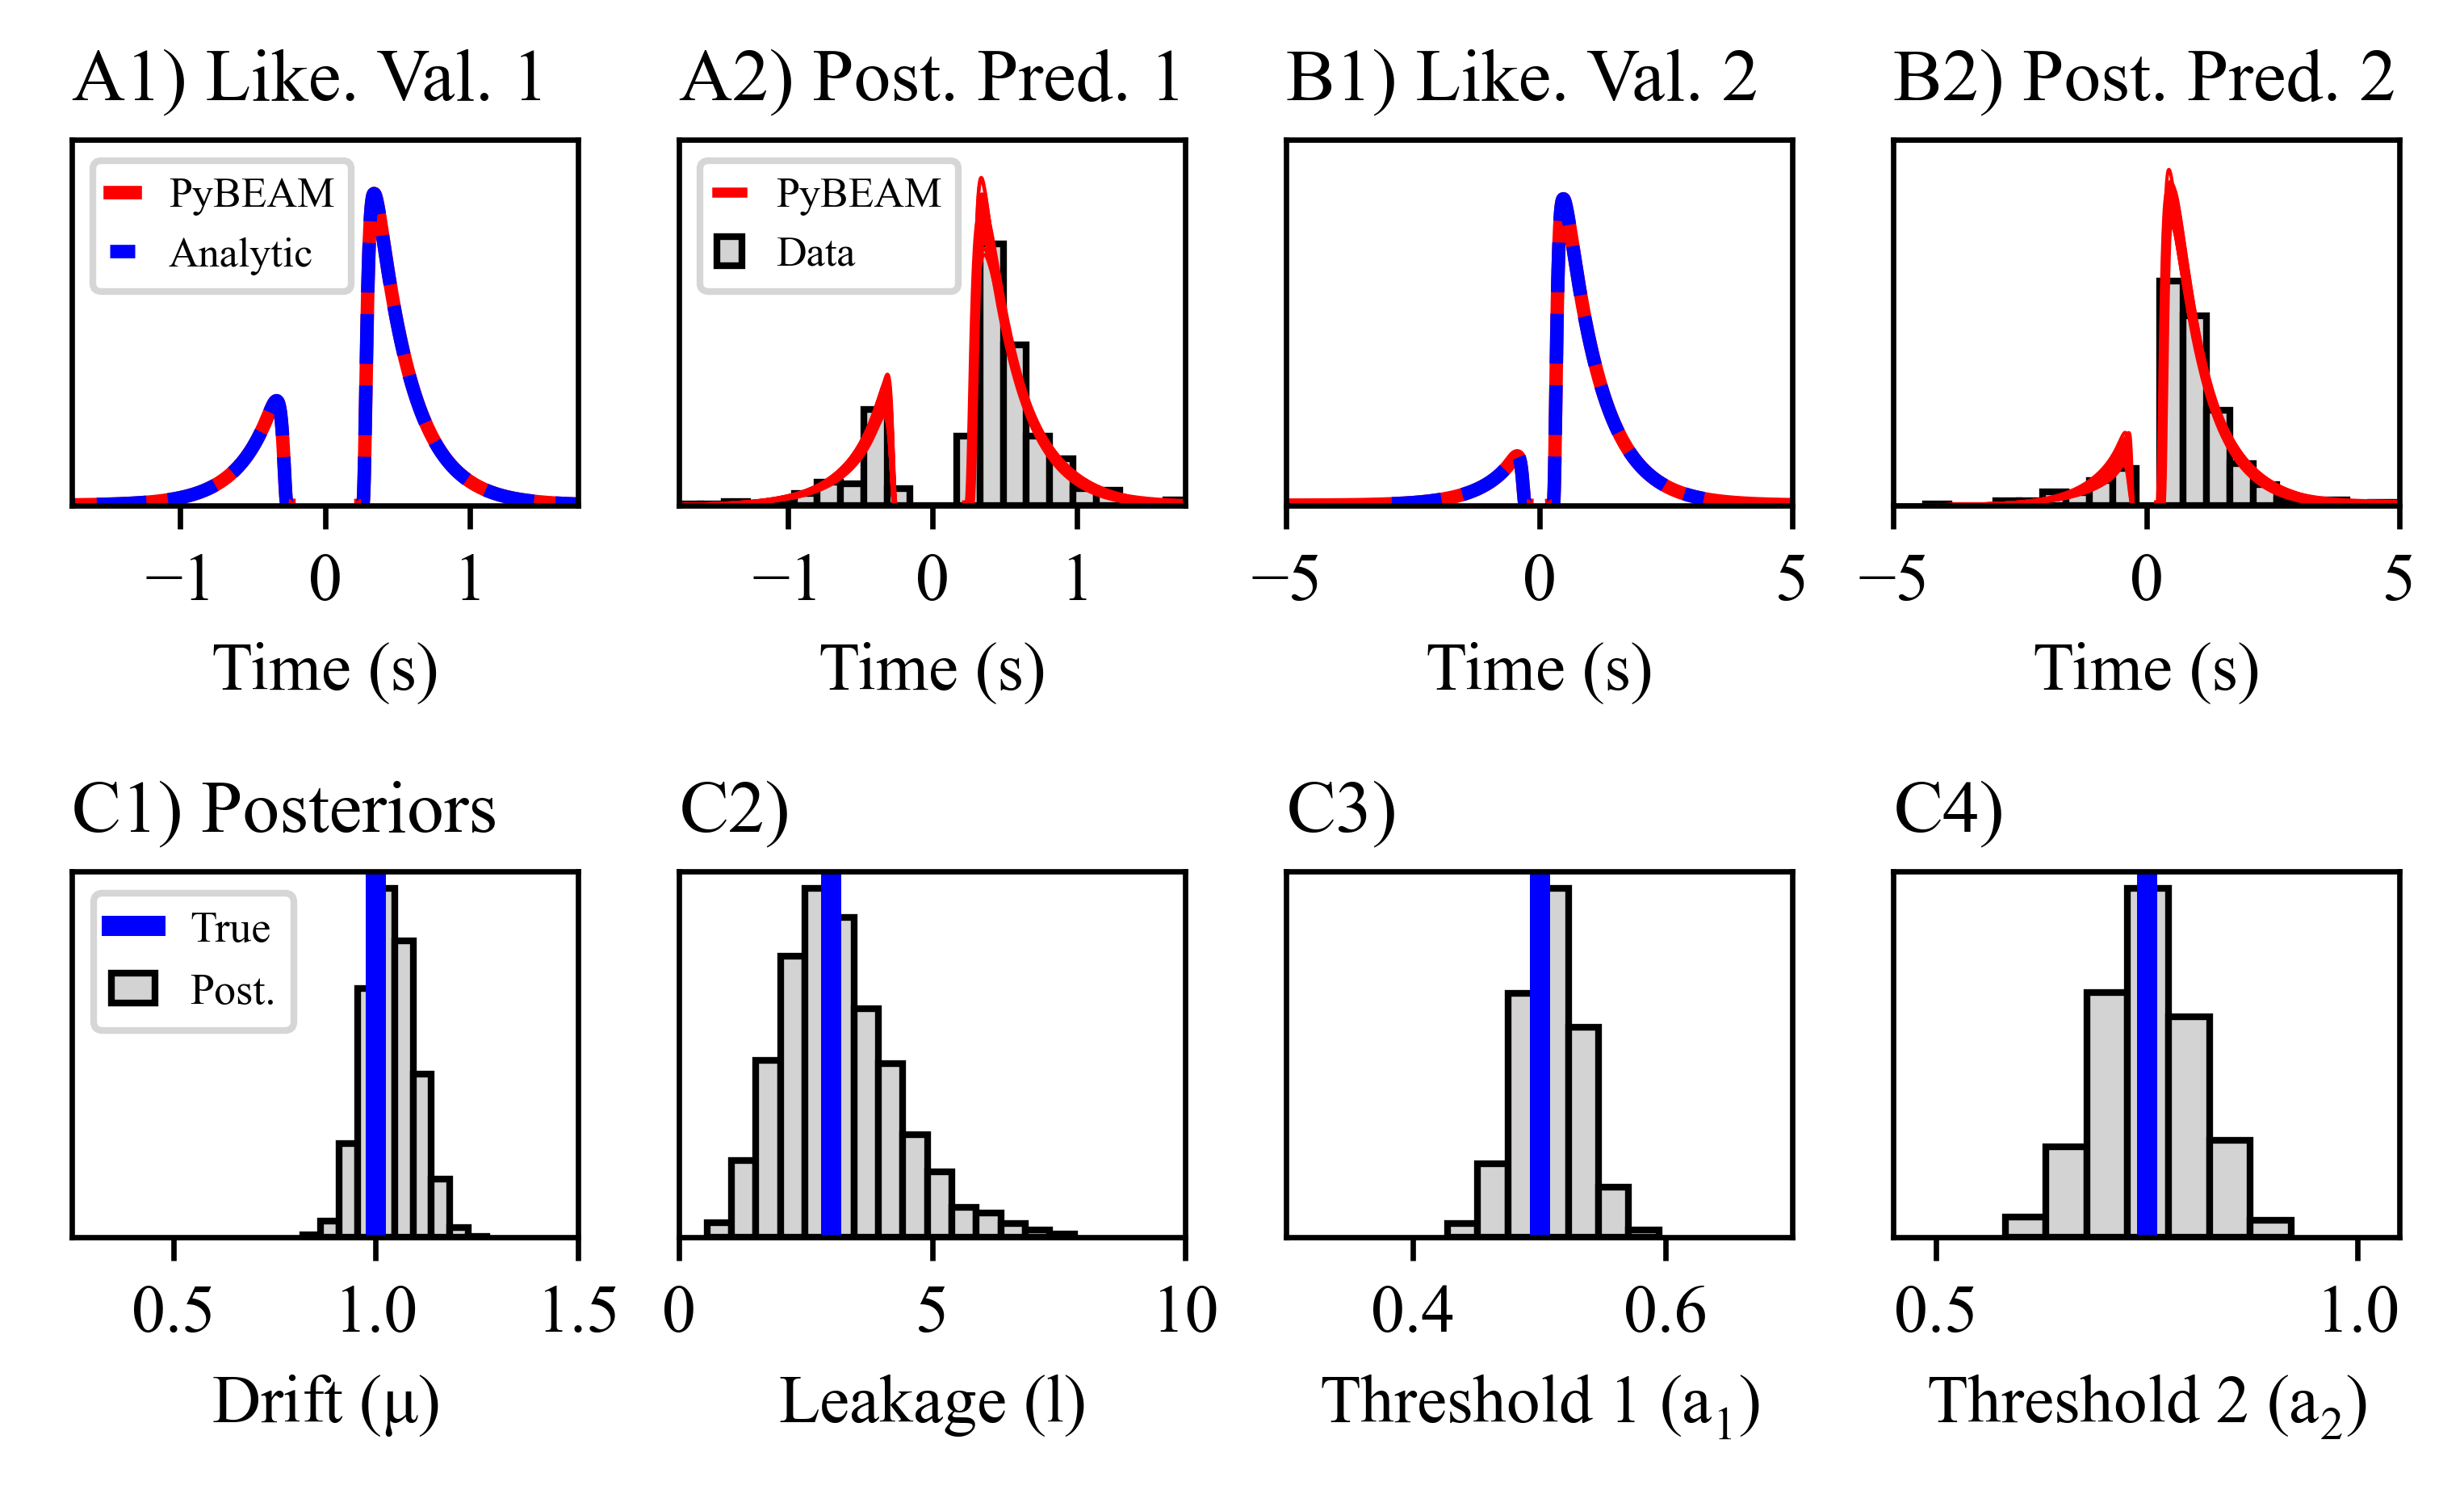

In [28]:
# -------------------------------------------------- #
# define figure
# -------------------------------------------------- #

fig, axs = plt.subplots(2, 4, figsize=(6.2, 3.0), dpi=600);
plt.subplots_adjust(hspace=1.0)

# -------------------------------------------------- #
# load trace
# -------------------------------------------------- #

file_name = 'leakage_2boundary'
burnin = 12500
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

t_nd = trace.t_nd.values
w = trace.w.values
mu = trace.mu.values
l = trace.l.values
a0 = trace.a0.values
a1 = trace.a1.values

# -------------------------------------------------- #
# generate panel [0,0]
# -------------------------------------------------- #

model_rt = pbd.model_rt(model = model, phi = phi0)
axs[0,0].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2)
axs[0,0].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2, label = '_nolegend_')

# import analytic solutions
t_leakage0 = np.loadtxt('t_leakage0.csv', delimiter = ',')
rt_leakage0u = np.loadtxt('rt_leakage0u.csv', delimiter = ',')
rt_leakage0l = np.loadtxt('rt_leakage0l.csv', delimiter = ',')
axs[0,0].plot(t_leakage0 + phi0['t_nd'], rt_leakage0u, color = 'b', linestyle = '--', linewidth = 2)
axs[0,0].plot(-(t_leakage0 + phi0['t_nd']), rt_leakage0l, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)

axs[0,0].set_xlim(-1.75, 1.75)
axs[0,0].set_title('A1) Like. Val. 1', loc = 'left', fontsize = 11)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].legend(['PyBEAM', 'Analytic'], fontsize = 6.25, loc = 'upper left', handlelength = 0.6)

# -------------------------------------------------- #
# generate panel [0,1]
# -------------------------------------------------- #

rt0_all = np.concatenate((rt0['rt_upper'], -rt0['rt_lower']))
axs[0,1].hist(rt0_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd))
    t_nd_ind = t_nd[ind]
    w_ind = w[ind]
    mu_ind = mu[ind]
    l_ind = l[ind]
    a_ind = a0[ind] 

    phi_temp = { 't_nd' : t_nd_ind,
            'w' : w_ind,
            'mu' : mu_ind,
            'l' : l_ind,
            'a' : a_ind} 
       
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
    
axs[0,1].set_xlim(-1.75, 1.75)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_title('A2) Post. Pred. 1', loc = 'left', fontsize = 11)
axs[0,1].legend(['PyBEAM', 'Data'], fontsize = 6.25, loc = 'upper left', handlelength = 0.6)

# -------------------------------------------------- #
# generate panel [0,2]
# -------------------------------------------------- #

model_rt = pbd.model_rt(model = model, phi = phi1)
axs[0,2].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2)
axs[0,2].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2, label = '_nolegend_')

# import analytic solutions
t_leakage1 = np.loadtxt('t_leakage1.csv', delimiter = ',')
rt_leakage1u = np.loadtxt('rt_leakage1u.csv', delimiter = ',')
rt_leakage1l = np.loadtxt('rt_leakage1l.csv', delimiter = ',')
axs[0,2].plot(t_leakage1 + phi1['t_nd'], rt_leakage1u, color = 'b', linestyle = '--', linewidth = 2)
axs[0,2].plot(-(t_leakage1 + phi1['t_nd']), rt_leakage1l, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)

axs[0,2].set_xlim(-5.0, 5.0)
axs[0,2].set_title('B1) Like. Val. 2', loc = 'left', fontsize = 11)
axs[0,2].set_xlabel('Time (s)')
# axs[0,2].legend(['PyBEAM', 'Sim.'], fontsize = 6.25, loc = 'upper left', handlelength = 0.6)

# -------------------------------------------------- #
# generate panel [0,3]
# -------------------------------------------------- #

# plot hyperbolic weibull posterior predictive

rt1_all = np.concatenate((rt1['rt_upper'], -rt1['rt_lower']))
axs[0,3].hist(rt1_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd))
    t_nd_ind = t_nd[ind]
    w_ind = w[ind]
    mu_ind = mu[ind]
    l_ind = l[ind]
    a_ind = a1[ind] 

    phi_temp = { 't_nd' : t_nd_ind,
            'w' : w_ind,
            'mu' : mu_ind,
            'l' : l_ind,
            'a' : a_ind} 
    
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
    
axs[0,3].set_xlim(-5.0, 5.0)
axs[0,3].set_xlabel('Time (s)')
axs[0,3].set_title('B2) Post. Pred. 2', loc = 'left', fontsize = 11)

# -------------------------------------------------- #
# generate panels [1,0] thru [1,3]
# -------------------------------------------------- #

axs[1,0].hist(mu, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,0].set_xlabel('Drift ($\mu$)')
axs[1,0].axvline(x=1.0, c = 'b', linewidth = 3)
axs[1,0].set_xlim(0.25, 1.5)
axs[1,0].set_title('C1) Posteriors', loc = 'left', fontsize = 11)
axs[1,0].legend(['True', 'Post.'], fontsize = 6.5, handlelength = 1.0)

axs[1,1].hist(l, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,1].set_xlabel('Leakage ($l$)')
axs[1,1].axvline(x=3.0, c = 'b', linewidth = 3)
axs[1,1].set_title('C2)', loc = 'left', fontsize = 11)
axs[1,1].set_xlim(0.0, 10.0)

axs[1,2].hist(a0, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,2].set_xlabel('Threshold 1 ($a_{1}$)')
axs[1,2].axvline(x=0.5, c = 'b', linewidth = 3)
axs[1,2].set_title('C3)', loc = 'left', fontsize = 11)
axs[1,2].set_xlim(0.3, 0.7)

axs[1,3].hist(a1, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,3].set_xlabel('Threshold 2 ($a_{2}$)')
axs[1,3].axvline(x=0.75, c = 'b', linewidth = 3)
axs[1,3].set_title('C4)', loc = 'left', fontsize = 11)
axs[1,3].set_xlim(0.45, 1.05)

# -------------------------------------------------- #
# modify axes and labels
# -------------------------------------------------- #

for ii in range(1):
    for jj in range(2):
        axs[ii,jj].set_ylim([0.0, 2.75])

for ii in range(1):
    for jj in range(2,4):
        axs[ii,jj].set_ylim([0.0, 1.15])
        
for ii in range(2):
    for jj in range(4):
        axs[ii,jj].set_yticklabels([])
        axs[ii,jj].set_yticks([])
        
plt.savefig('leakage.pdf', bbox_inches = 'tight', dpi = 600)
        

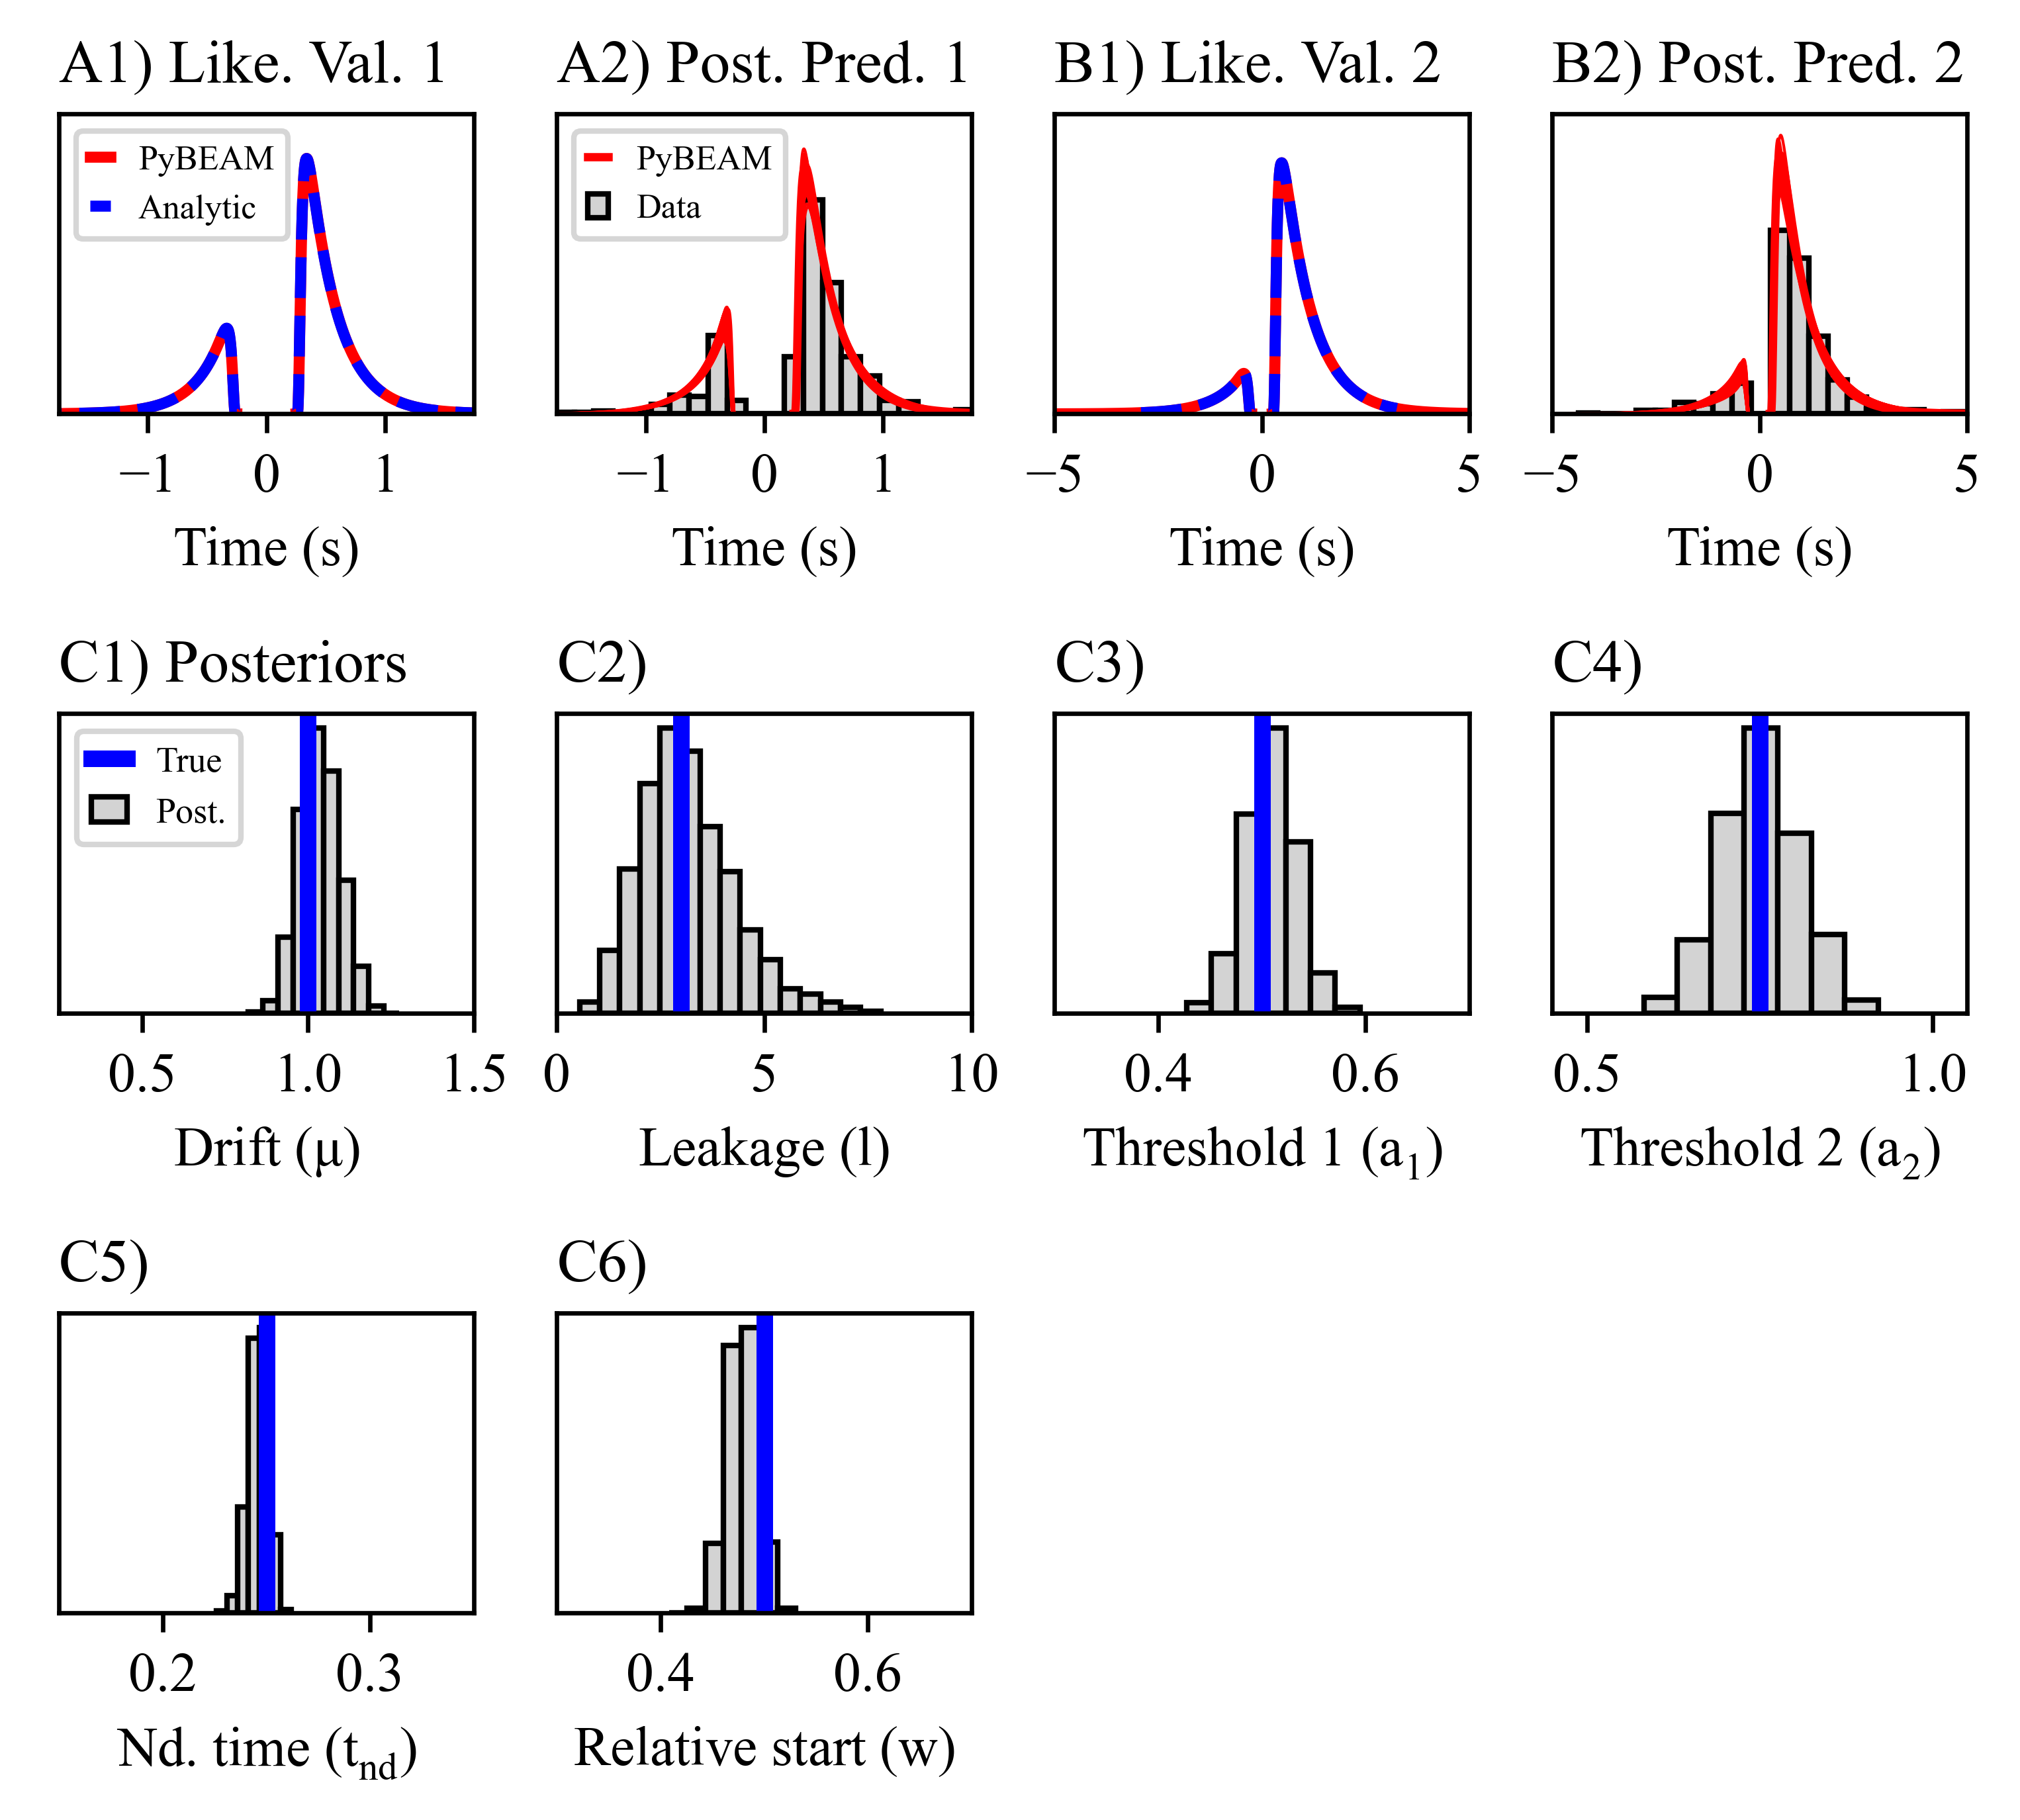

In [35]:
# -------------------------------------------------- #
# define figure
# -------------------------------------------------- #

fig, axs = plt.subplots(3, 4, figsize=(6.2, 5.0), dpi=600);
plt.subplots_adjust(hspace=1.0)

# -------------------------------------------------- #
# load trace
# -------------------------------------------------- #

file_name = 'leakage_2boundary'
burnin = 12500
trace = az.from_netcdf(file_name + '.nc')
trace = trace.sel(draw=slice(burnin,None))
trace = trace.posterior.stack(draws=("chain", "draw"))

t_nd = trace.t_nd.values
w = trace.w.values
mu = trace.mu.values
l = trace.l.values
a0 = trace.a0.values
a1 = trace.a1.values

# -------------------------------------------------- #
# generate panel [0,0]
# -------------------------------------------------- #

model_rt = pbd.model_rt(model = model, phi = phi0)
axs[0,0].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2)
axs[0,0].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2, label = '_nolegend_')

# import analytic solutions
t_leakage0 = np.loadtxt('t_leakage0.csv', delimiter = ',')
rt_leakage0u = np.loadtxt('rt_leakage0u.csv', delimiter = ',')
rt_leakage0l = np.loadtxt('rt_leakage0l.csv', delimiter = ',')
axs[0,0].plot(t_leakage0 + phi0['t_nd'], rt_leakage0u, color = 'b', linestyle = '--', linewidth = 2)
axs[0,0].plot(-(t_leakage0 + phi0['t_nd']), rt_leakage0l, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)

axs[0,0].set_xlim(-1.75, 1.75)
axs[0,0].set_title('A1) Like. Val. 1', loc = 'left', fontsize = 11)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].legend(['PyBEAM', 'Analytic'], fontsize = 6.25, loc = 'upper left', handlelength = 0.6)

# -------------------------------------------------- #
# generate panel [0,1]
# -------------------------------------------------- #

rt0_all = np.concatenate((rt0['rt_upper'], -rt0['rt_lower']))
axs[0,1].hist(rt0_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd))
    t_nd_ind = t_nd[ind]
    w_ind = w[ind]
    mu_ind = mu[ind]
    l_ind = l[ind]
    a_ind = a0[ind] 

    phi_temp = { 't_nd' : t_nd_ind,
            'w' : w_ind,
            'mu' : mu_ind,
            'l' : l_ind,
            'a' : a_ind} 
       
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,1].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,1].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
    
axs[0,1].set_xlim(-1.75, 1.75)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_title('A2) Post. Pred. 1', loc = 'left', fontsize = 11)
axs[0,1].legend(['PyBEAM', 'Data'], fontsize = 6.25, loc = 'upper left', handlelength = 0.6)

# -------------------------------------------------- #
# generate panel [0,2]
# -------------------------------------------------- #

model_rt = pbd.model_rt(model = model, phi = phi1)
axs[0,2].plot(model_rt['time'], model_rt['model_rt_upper'], color = 'red', linewidth = 2)
axs[0,2].plot(-model_rt['time'], model_rt['model_rt_lower'], color = 'red', linewidth = 2, label = '_nolegend_')

# import analytic solutions
t_leakage1 = np.loadtxt('t_leakage1.csv', delimiter = ',')
rt_leakage1u = np.loadtxt('rt_leakage1u.csv', delimiter = ',')
rt_leakage1l = np.loadtxt('rt_leakage1l.csv', delimiter = ',')
axs[0,2].plot(t_leakage1 + phi1['t_nd'], rt_leakage1u, color = 'b', linestyle = '--', linewidth = 2)
axs[0,2].plot(-(t_leakage1 + phi1['t_nd']), rt_leakage1l, color = 'b', linestyle = '--', label = '_nolegend_', linewidth = 2)

axs[0,2].set_xlim(-5.0, 5.0)
axs[0,2].set_title('B1) Like. Val. 2', loc = 'left', fontsize = 11)
axs[0,2].set_xlabel('Time (s)')
# axs[0,2].legend(['PyBEAM', 'Sim.'], fontsize = 6.25, loc = 'upper left', handlelength = 0.6)

# -------------------------------------------------- #
# generate panel [0,3]
# -------------------------------------------------- #

# plot hyperbolic weibull posterior predictive

rt1_all = np.concatenate((rt1['rt_upper'], -rt1['rt_lower']))
axs[0,3].hist(rt1_all, density = True, bins = 25, edgecolor = 'k', facecolor = 'lightgrey');

N_pp = 100
for ii in range(N_pp):
    
    ind = np.random.randint(0, len(t_nd))
    t_nd_ind = t_nd[ind]
    w_ind = w[ind]
    mu_ind = mu[ind]
    l_ind = l[ind]
    a_ind = a1[ind] 

    phi_temp = { 't_nd' : t_nd_ind,
            'w' : w_ind,
            'mu' : mu_ind,
            'l' : l_ind,
            'a' : a_ind} 
    
    rt_model = pbd.model_rt(model = model, phi = phi_temp)
    if (ii == 0):
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label = '_nolegend_')
    else:
        axs[0,3].plot(rt_model['time'], rt_model['model_rt_upper'], color = 'r', linewidth = 0.5, label='_nolegend_')
        axs[0,3].plot(-rt_model['time'], rt_model['model_rt_lower'], color = 'r', linewidth = 0.5, label='_nolegend_')
    
axs[0,3].set_xlim(-5.0, 5.0)
axs[0,3].set_xlabel('Time (s)')
axs[0,3].set_title('B2) Post. Pred. 2', loc = 'left', fontsize = 11)

# -------------------------------------------------- #
# generate panels [1,0] thru [1,3]
# -------------------------------------------------- #

axs[1,0].hist(mu, density = True, bins = 10, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,0].set_xlabel('Drift ($\mu$)')
axs[1,0].axvline(x=1.0, c = 'b', linewidth = 3)
axs[1,0].set_xlim(0.25, 1.5)
axs[1,0].set_title('C1) Posteriors', loc = 'left', fontsize = 11)
axs[1,0].legend(['True', 'Post.'], fontsize = 6.5, handlelength = 1.0)

axs[1,1].hist(l, density = True, bins = 15, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,1].set_xlabel('Leakage ($l$)')
axs[1,1].axvline(x=3.0, c = 'b', linewidth = 3)
axs[1,1].set_title('C2)', loc = 'left', fontsize = 11)
axs[1,1].set_xlim(0.0, 10.0)

axs[1,2].hist(a0, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,2].set_xlabel('Threshold 1 ($a_{1}$)')
axs[1,2].axvline(x=0.5, c = 'b', linewidth = 3)
axs[1,2].set_title('C3)', loc = 'left', fontsize = 11)
axs[1,2].set_xlim(0.3, 0.7)

axs[1,3].hist(a1, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[1,3].set_xlabel('Threshold 2 ($a_{2}$)')
axs[1,3].axvline(x=0.75, c = 'b', linewidth = 3)
axs[1,3].set_title('C4)', loc = 'left', fontsize = 11)
axs[1,3].set_xlim(0.45, 1.05)

axs[2,0].hist(t_nd, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,0].set_xlabel('Nd. time ($t_{nd}$)')
axs[2,0].axvline(x=0.25, c = 'b', linewidth = 3)
axs[2,0].set_title('C5)', loc = 'left', fontsize = 11)
axs[2,0].set_xlim(0.15, 0.35)

axs[2,1].hist(w, density = True, bins = 7, edgecolor = 'k', facecolor = 'lightgrey');
axs[2,1].set_xlabel('Relative start ($w$)')
axs[2,1].axvline(x=0.5, c = 'b', linewidth = 3)
axs[2,1].set_title('C6)', loc = 'left', fontsize = 11)
axs[2,1].set_xlim(0.3, 0.7)

# -------------------------------------------------- #
# modify axes and labels
# -------------------------------------------------- #

for ii in range(1):
    for jj in range(2):
        axs[ii,jj].set_ylim([0.0, 2.75])

for ii in range(1):
    for jj in range(2,4):
        axs[ii,jj].set_ylim([0.0, 1.15])
        
for ii in range(3):
    for jj in range(4):
        axs[ii,jj].set_yticklabels([])
        axs[ii,jj].set_yticks([])
        
axs[2,2].set_axis_off()
axs[2,3].set_axis_off()
        
plt.savefig('leakage_full.pdf', bbox_inches = 'tight', dpi = 600)
        